In [1]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

from model.ONN import ONNModel, FSpropagation
from utils.loss_metrics import loss, grad, optimizer_init
from utils.utils_func import TestDataLoader, detector_regions


In [2]:
# load params
units = int(56)
distance = 5e-2 # plane spacing
lamb = 1565e-9 # wavelength
pixelSize = 8e-6
Nx = units 
Ny = units

# initiate dataloader
TDL = TestDataLoader(units)
# load pretraiend model
pretrained_model = tf.keras.models.load_model("./saved_model/dataset60000_epo_5_lr_1e2_56", compile=False)
pretrained_model.summary()

Model: "onn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f_spropagation (FSpropagati  multiple                 0         
 on)                                                             
                                                                 
 optical_layer (opticalLayer  multiple                 3136      
 )                                                               
                                                                 
 optical_layer_1 (opticalLay  multiple                 3136      
 er)                                                             
                                                                 
 optical_layer_2 (opticalLay  multiple                 3136      
 er)                                                             
                                                                 
 optical_layer_3 (opticalLay  multiple                 31

In [3]:
def phase_modulation(input, phase):
    imag_phi = tf.math.exp(1j*tf.cast(phase, dtype = tf.complex64))
    return tf.math.multiply(input, imag_phi)

def tf_propagation(input, Nx, Ny, lamb, distance, pixelSize):
    # (@REF: "MPLC_StartHere.m" - J.Carpenter)
    # //TODO: how to setup k-space coordinate system? - DONE
    X = (tf.range(1, Ny + 1, dtype = tf.float32) - Ny / 2 - 0.5) * pixelSize
    Y = (tf.range(1, Nx + 1, dtype = tf.float32) - Nx / 2 - 0.5) * pixelSize

    [X, Y] = tf.meshgrid(X, Y)

    fs_x = Nx / (tf.math.reduce_max(X) - tf.math.reduce_min(X))
    fs_y = Ny / (tf.math.reduce_max(Y) - tf.math.reduce_min(Y))

    v_x = fs_x*(tf.range(-Nx / 2, Nx / 2, dtype = tf.float32) / Nx)
    v_y = fs_y*(tf.range(-Ny / 2, Ny / 2, dtype = tf.float32) / Ny)
    [V_X, V_Y] = tf.meshgrid(v_x, v_y)
    
    # Free-space transfer function
    sqr = tf.cast(tf.sqrt(1 / lamb ** 2 - V_X ** 2 - V_Y ** 2), dtype=tf.complex64)
    tfcoef = tf.constant(-2j * np.pi * distance, dtype = tf.complex64) * sqr
    H = tf.exp(tfcoef * distance)

    # Free-space propagation
    input_fft = tf.signal.fftshift(tf.signal.fft2d(input))
    output = tf.signal.ifft2d(tf.signal.ifftshift(tf.multiply(H, input_fft)))

    return output

In [4]:
# testing layers
trained_vars = pretrained_model.trainable_variables 

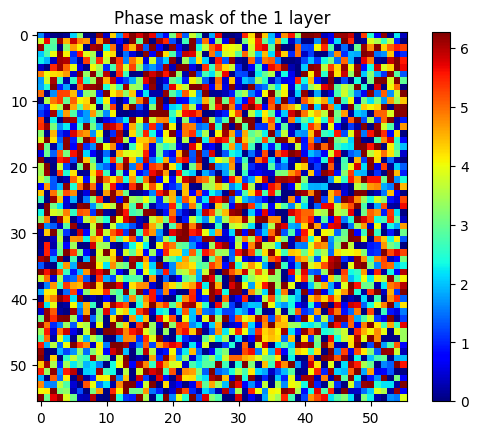

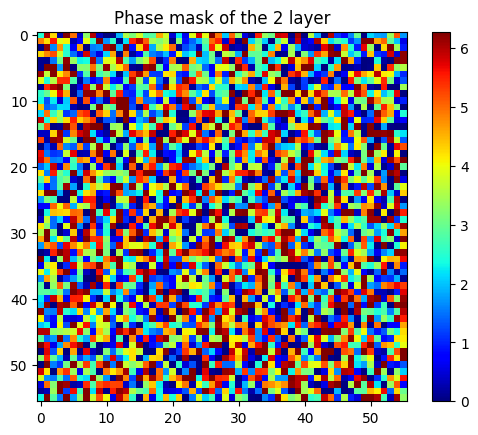

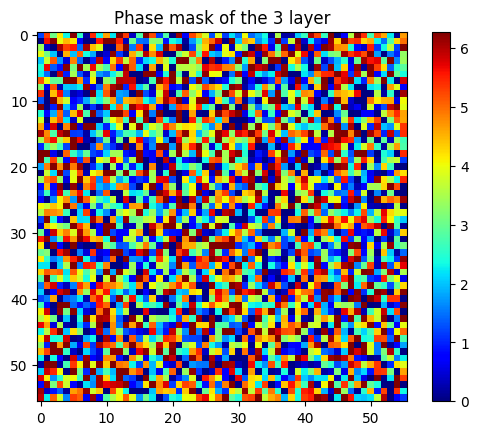

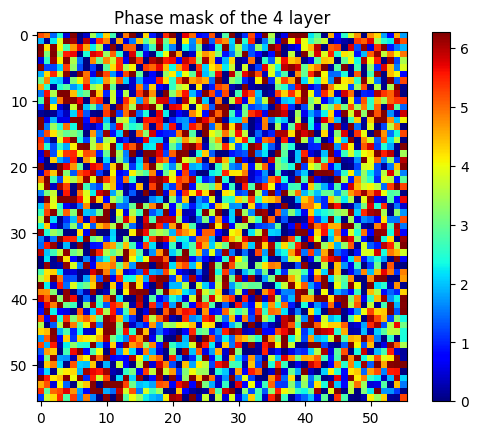

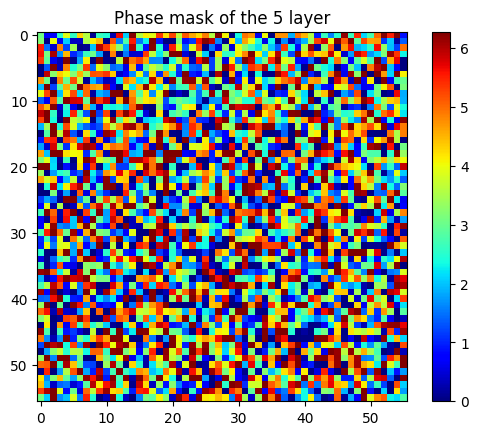

In [5]:
#display the phase masks
for i in range(len(trained_vars)):
    layer_pha = np.array(trained_vars[i])

    plt.figure()
    plt.imshow(layer_pha, cmap="jet")
    plt.colorbar()
    plt.title(f"Phase mask of the {i+1} layer")
    plt.show()


### **Test the pretrained variables**

Text(0.5, 1.0, 'Output pattern, predicted label is 0')

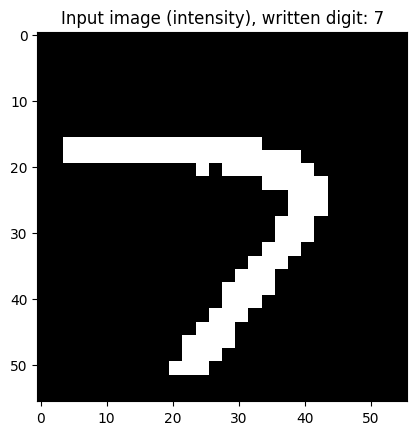

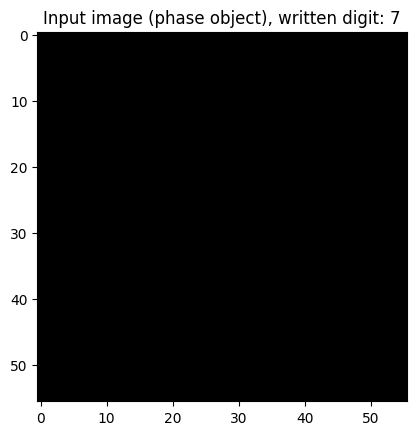

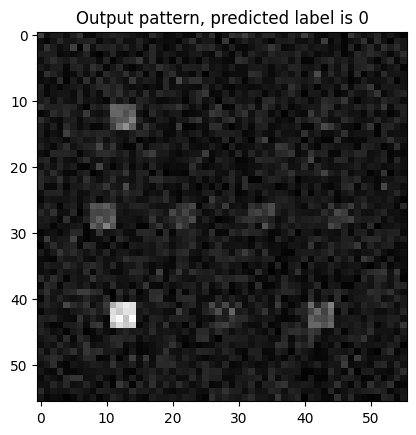

In [7]:
test_num = 70
test_img_batch, test_label_batch = TDL[0:100]
test_img = test_img_batch[test_num]
test_label = test_label_batch[test_num]
test_out = pretrained_model(test_img, training=False)

# Get the predicition
detector_readings = detector_regions(test_out)
predicted_label = tf.argmax(detector_readings)

plt.figure()
plt.imshow(tf.abs(test_img), cmap="gray")
plt.title(f"Input image (intensity), written digit: {test_label}")
plt.figure()
plt.imshow(np.angle(test_img.numpy().squeeze()), cmap="gray")
plt.title(f"Input image (phase object), written digit: {test_label}")
plt.figure()
plt.imshow(tf.abs(test_out), cmap="gray")
plt.title(f"Output pattern, predicted label is {predicted_label}")


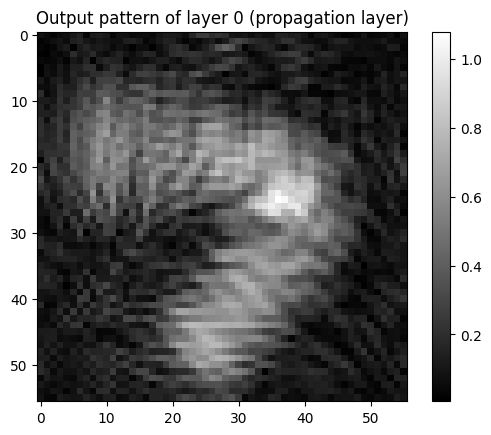

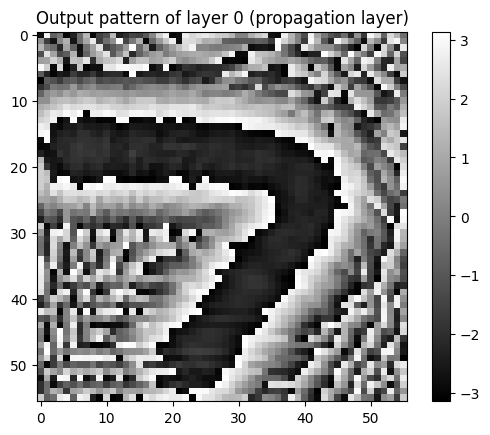

In [8]:
# Layer 0
input = tf.cast(test_img, dtype=tf.complex64)
propagation_layer = FSpropagation(200, distance, lamb, Nx, Ny, pixelSize)
out_0 = propagation_layer(input)

plt.figure()
plt.imshow(tf.abs(out_0), cmap="gray")
plt.title(f"Output pattern of layer 0 (propagation layer)")
plt.colorbar()
plt.figure()
plt.imshow(np.angle(out_0.numpy().squeeze()), cmap="gray")
plt.title(f"Output pattern of layer 0 (propagation layer)")
plt.colorbar()

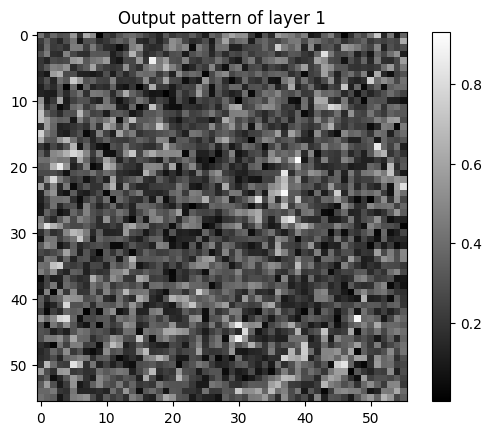

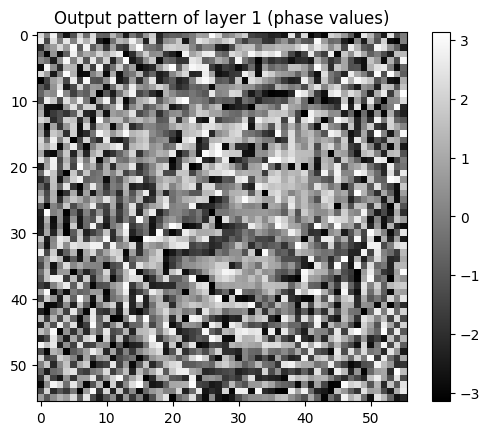

In [9]:
# Layer 1
phase_1 = trained_vars[0]

out_1 = tf_propagation(phase_modulation(out_0, phase_1), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_1), cmap="gray")
plt.title(f"Output pattern of layer 1")
plt.colorbar()
plt.figure()
plt.imshow(np.angle(out_1.numpy().squeeze()), cmap="gray")
plt.title(f"Output pattern of layer 1 (phase values)")
plt.colorbar()

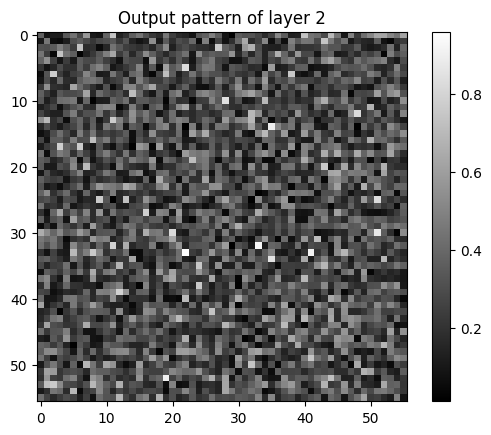

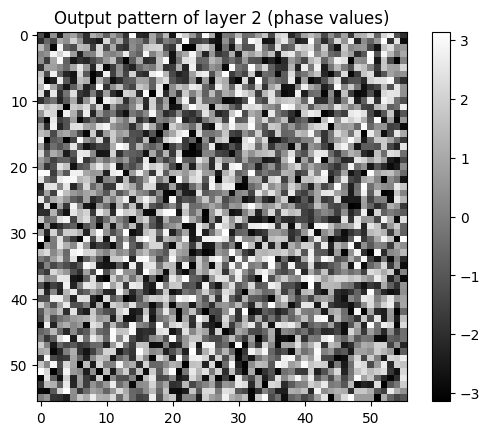

In [10]:
# Layer 2
phase_2 = trained_vars[1]

out_2 = tf_propagation(phase_modulation(out_1, phase_2), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_2), cmap="gray")
plt.title(f"Output pattern of layer 2")
plt.colorbar()
plt.figure()
plt.imshow(np.angle(out_2.numpy().squeeze()), cmap="gray")
plt.title(f"Output pattern of layer 2 (phase values)")
plt.colorbar()

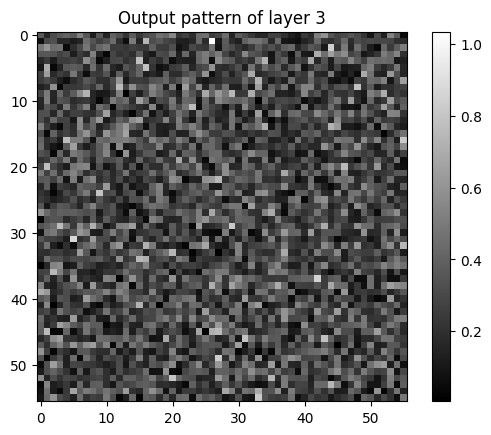

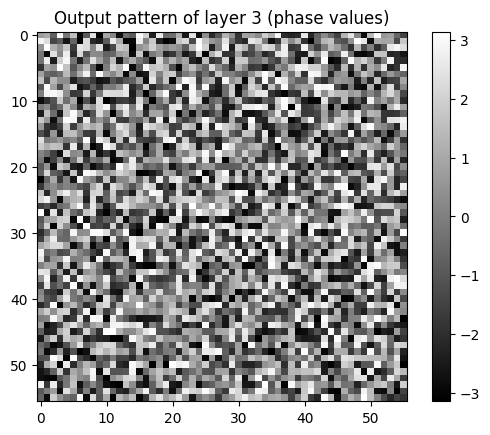

In [11]:
# Layer 3
phase_3 = trained_vars[2]

out_3 = tf_propagation(phase_modulation(out_2, phase_3), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_3), cmap="gray")
plt.title(f"Output pattern of layer 3")
plt.colorbar()
plt.figure()
plt.imshow(np.angle(out_3.numpy().squeeze()), cmap="gray")
plt.title(f"Output pattern of layer 3 (phase values)")
plt.colorbar()

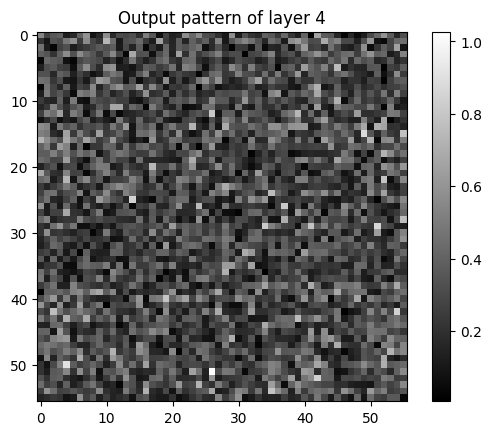

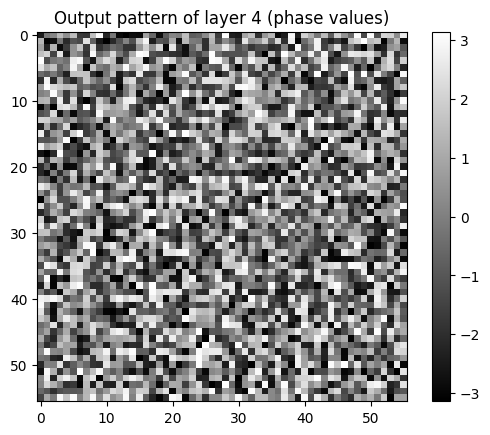

In [12]:
# Layer 4
phase_4 = trained_vars[3]

out_4 = tf_propagation(phase_modulation(out_3, phase_4), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_4), cmap="gray")
plt.title(f"Output pattern of layer 4")
plt.colorbar()
plt.figure()
plt.imshow(np.angle(out_4.numpy().squeeze()), cmap="gray")
plt.title(f"Output pattern of layer 4 (phase values)")
plt.colorbar()

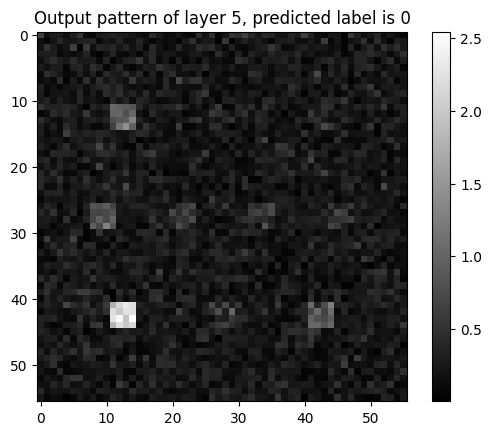

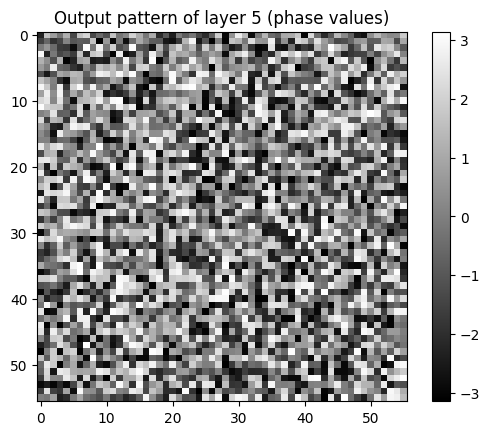

In [13]:
# Layer 5
phase_5 = trained_vars[4]

out_5 = tf_propagation(phase_modulation(out_4, phase_5), Nx, Ny, lamb, distance, pixelSize)
# Get the predicition
detector_readings = detector_regions(out_5)
predicted_label = tf.argmax(detector_readings)

plt.figure()
plt.imshow(tf.abs(out_5), cmap="gray")
plt.title(f"Output pattern of layer 5, predicted label is {predicted_label}")
plt.colorbar()
plt.figure()
plt.imshow(np.angle(out_5.numpy().squeeze()), cmap="gray")
plt.title(f"Output pattern of layer 5 (phase values)")
plt.colorbar()